In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import sympy

import pickle

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (10, 8)

In [3]:
def derivative(f, x, h=0.001):
    return (f(x + h) - f(x - h)) / (2*h)

In [4]:
class Object:
    def y_coords(self, x):
        pass

    def normal_line_slope(self, y):
        pass

    def collides_with(self, ray_x, ray_y, ray_slope):
        pass

In [18]:
class Circle(Object):
    def __init__(self, x0, y0, radius, end_length):
        self.x0 = x0
        self.y0 = y0
        self.end_length = end_length
        self.r = radius

    def y_coords(self, x):
        if self.x0 - self.end_length / 2 <= x <= self.x0 + self.end_length / 2:
            return np.sqrt(self.r**2 - (x - self.x0)**2) + self.y0
        else:
            raise ValueError('X is outside object range, x: {}, x0-end_length: {}'.format(x, self.x0 - self.end_length / 2))

    def normal_line_slope(self, x):
        return -1 / derivative(self.y_coords, x)

    def collides_with(self, ray_x, ray_y, ray_slope):
        if (ray_slope is np.inf or ray_slope > 10**9) and self.x0 - self.r <= ray_x <= self.x0 + self.r:

            y = self.y_coords(ray_x)
            if y == np.nan:
                return None

            return [(ray_x, y)]

        ray_x -= self.x0
        ray_offset = ray_y - ray_slope * ray_x

        if ray_offset == 0:
            d = 0
        elif ray_slope == 0:
            d = ray_offset
        elif math.copysign(1, ray_offset) == math.copysign(1, ray_slope):
            d = -np.abs(((-ray_offset / ray_slope) * ray_offset) / np.sqrt((-ray_offset / ray_slope)**2 + ray_offset**2))
        else:
            d = -np.abs(((-ray_offset / ray_slope) * ray_offset) / np.sqrt((-ray_offset / ray_slope)**2 + ray_offset**2))

        if np.abs(d) > self.r:
            return None

        normal_line_angle = np.arctan(-1 / ray_slope)

        # Coordinates of point closest to circle origin.
        x_d = np.cos(normal_line_angle) * d
        y_d = np.sin(normal_line_angle) * d

        # Distance between point closest to circle origin and the intersection points.
        d_i = np.sqrt(self.r**2 - d**2)

        slope_angle = np.arctan(ray_slope)

        x_1 = np.cos(slope_angle) * d_i + x_d
        x_2 = np.cos(slope_angle) * (-d_i) + x_d

        y_1 = np.sin(slope_angle) * d_i + y_d
        y_2 = np.sin(slope_angle) * (-d_i) + y_d

        if x_1 == np.nan:
            x_1 = None
        if x_2 == np.nan:
            x_2 = None

        if y_1 == np.nan:
            y_1 = None
        if y_2 == np.nan:
            y_2 = None

        if np.isclose(x_1, x_2):
            return [(x_1, y_1)]
        else:
            return [(x_1, y_1), (x_2, y_2)]

In [6]:
class Line(Object):
    def __init__(self, x0, x1, y0, y1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1

        self.slope = (self.y1 - self.y0) / (self.x1 - self.x0)
        self.offset = self.y0 - self.slope * self.x0

    def y_coords(self, x):
        return self.slope * x + self.offset

    def normal_line_slope(self, x):
        return np.inf if self.y0 - self.y1 == 0 else -1 / derivative(self.y_coords, x)

    def collides_with(self, ray_x, ray_y, ray_slope):
        if ray_slope is np.inf:
            if self.x0 <= ray_x <= self.x1:
                return [(ray_x, self.y_coords(ray_x))]
            return None

        col_x = (ray_slope*ray_x - ray_y + self.offset) / (ray_slope - self.slope)

        if self.x0 <= col_x <= self.x1:
            return [(col_x, self.y_coords(col_x))]

        return None

In [7]:
class Ray:
    def __init__(self, x0, y0, initial_slope=np.inf, initial_dir='R', color='red'):
        self.x = x0
        self.y = y0
        self.slope = initial_slope
        self.offset = self.y - self.slope * self.x
        self.dir = initial_dir
        self.collisions = 0
        self.prev_dir = self.dir
        self.reflection = False
        self.reflection_origin = None
        self.color = color

        self.points = [(self.x, self.y)]

    def get_collisions(self):
        return self.collisions

    def update(self, x, y, slope, dir, new_collision=True):
        self.prev_dir = dir
        self.points.append((x, y))
        self.x = x
        self.y = y
        self.slope = slope
        self.offset = self.y - self.slope * self.x
        self.dir = dir

        if new_collision:
            self.collisions += 1

In [8]:
def point_slope(x_point, y_point, y, slope):
    return (slope * x_point + y - y_point) / slope

In [9]:
def critical_angle(refr_idx_1, refr_idx_2):
    return np.arcsin(refr_idx_2 / refr_idx_1)

In [10]:
def snell_refraction(refr_idx_1, refr_idx_2, angle_1):
    return math.asin(np.sin(angle_1) * refr_idx_1 / refr_idx_2)

In [11]:
def trace_ray(ray: Ray, objects, refr_idx, end):
    collisions = []

    for obj in objects:
        collisions = obj.collides_with(ray.x, ray.y, ray.slope)

        if collisions is None:
            continue

        for collision in collisions:
            if np.nan in collision:
                continue

            collision_x = collision[0]
            collision_y = collision[1]

            if ray.dir == 'R' and round(collision_y, 10) > round(ray.y, 10):
                collisions.append((collision_x, collision_y, obj))
            elif ray.dir == 'L' and round(collision_y, 10) < round(ray.y, 10):
                collisions.append((collision_x, collision_y, obj))

    if len(collisions) == 0:
        if ray.dir == 'R':
            ray.update(point_slope(ray.x, ray.y, end, ray.slope), end, ray.slope, 'R')
        elif ray.dir == 'L':
            ray.update(point_slope(ray.x, ray.y, -end, ray.slope), -end, ray.slope, 'L')
        return ray

    if ray.dir == 'R':
        collisions.sort(key=lambda col: col[1])
    else:
        collisions.sort(key=lambda col: col[1], reverse=True)

    norm_l_slope = collisions[0][2].normal_line_slope(collisions[0][0])

    norm_l_angle = math.atan(norm_l_slope)
    if norm_l_angle < 0:
        norm_l_angle += math.pi

    ray_angle = math.atan(ray.slope)
    if ray_angle < 0:
        ray_angle += math.pi

    angle_1 = ray_angle - norm_l_angle

    angle_2 = 0

    reflection = False

    if ray.collisions % 2 == 0:
        if round(abs(angle_1), 5) >= round(critical_angle(1, refr_idx), 5):
            if not ray.reflection:
                ray.reflection = True
                ray.reflection_origin = (collisions[0][0], collisions[0][1])
            reflection = True
            angle_2 = -angle_1
        else:
            ray.reflection = False
            angle_2 = snell_refraction(1, refr_idx, angle_1)
    if ray.collisions % 2 == 1:
        if round(abs(angle_1), 5) >= round(critical_angle(refr_idx, 1), 5):
            if not ray.reflection:
                ray.reflection = True
                ray.reflection_origin = (collisions[0][0], collisions[0][1])
            reflection = True
            angle_2 = -angle_1
        else:
            ray.reflection = False
            angle_2 = snell_refraction(refr_idx, 1, angle_1)

    if norm_l_angle >= 0:
        ray_slope = math.tan(norm_l_angle + angle_2)
    else:
        ray_slope = math.tan(norm_l_angle - angle_2)

    if reflection and (ray_slope < 0 or ray.prev_dir == 'L') and ray.reflection_origin[0] - collisions[0][2].x0 < 0:
        ray.update(collisions[0][0], collisions[0][1], ray_slope, 'L', new_collision=not reflection)
    elif reflection and (ray_slope > 0 or ray.prev_dir == 'L') and ray.reflection_origin[0] - collisions[0][2].x0 > 0:
        ray.update(collisions[0][0], collisions[0][1], ray_slope, 'L', new_collision=not reflection)
    else:
        ray.update(collisions[0][0], collisions[0][1], ray_slope, ray.prev_dir, new_collision=not reflection)

    return trace_ray(ray, objects, refr_idx, end)

In [19]:
length = 5
LPmm = 15 * 10**-1
end_chord = 1 / LPmm
h_to_l = 0.4
h = h_to_l * end_chord
w = 0.5

r = (4 * h**2 + end_chord**2) / (8 * h)
objects = []

for i in np.arange(0, length * LPmm + 1, 1):
    objects.append(Circle(-length/2 + i * end_chord, 0, r, end_chord))

objects.append(Line(-length/2, length/2, -w - (r - h), -w - (r - h)))

In [20]:
rays_x = np.arange(-2, 2, 0.1435)

rays = [Ray(x, -10) for x in rays_x]

In [21]:
rays = [rays[4]]

In [22]:
for i, ray in enumerate(rays):
    print('ray', i)
    ray = trace_ray(ray, objects, 1.489, 20)
    print('done')

ray 0
-inf
-inf


/tmp/ipykernel_65727/1387633921.py:38: RuntimeWarning: invalid value encountered in double_scalars
  d = -np.abs(((-ray_offset / ray_slope) * ray_offset) / np.sqrt((-ray_offset / ray_slope)**2 + ray_offset**2))


KeyboardInterrupt: 

In [17]:
rays[0].points

[(-1.4260000000000002, -10)]

In [75]:
rays[0].points.pop()

(126.95337737146716, 20)

In [76]:
rays[0].x = rays[0].points[-1][0]
rays[0].y = rays[0].points[-1][1]

In [77]:
rays[0].points

[(-1.4260000000000002, -10),
 (-1.4260000000000002, -0.575),
 (-1.4260000000000002, 0.22244624818893505)]

In [61]:
objects[2].r

0.3416666666666667

In [60]:
objects[2].collides_with(rays[0].x, rays[0].y, rays[0].slope)

0.2623979837764631


[0.18035989458377483, -0.2593333333333334]

In [ ]:
with open('sheet_3.pickle', 'wb') as ray_file:
    pickle.dump(rays, ray_file)

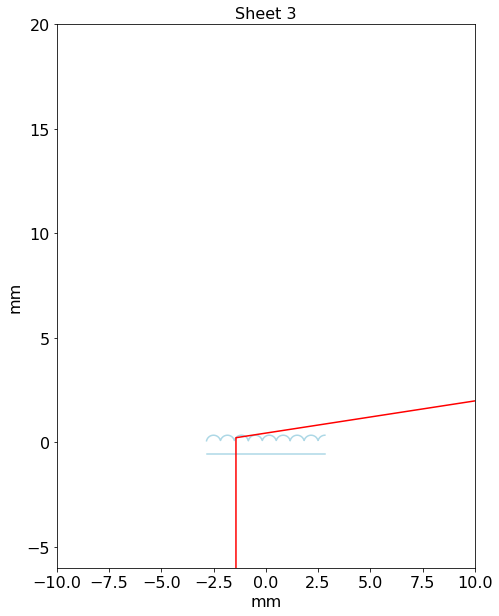

In [74]:
fig, ax = plt.subplots()

x_vals = np.arange(-length/2 - end_chord/2, length/2 + end_chord/2, 0.01)
y_coords = []

obj_idx = 0

for x in x_vals:
    try:
        y_coords.append(objects[obj_idx].y_coords(x))
    except ValueError:
        obj_idx += 1
        y_coords.append(objects[obj_idx].y_coords(x))

ax.plot(x_vals, y_coords, color='lightblue')
ax.plot(x_vals, objects[-1].y_coords(x_vals), color='lightblue')

for i, ray in enumerate(rays):
    ray_points = np.array(ray.points).swapaxes(0, 1)
    if i == 4:
        ax.plot(ray_points[0], ray_points[1], color='green')
    else:
        ax.plot(ray_points[0], ray_points[1], color='red')

plt.ylim(-6, 20)
plt.xlim(-10, 10)
plt.xlabel('mm')
plt.ylabel('mm')
ax.set_aspect(1)
ax.set_title('Sheet 3')
fig.set_size_inches(10, 10)
plt.show()

In [22]:
angles = []

for ray in rays:
    if ray.dir == 'L':
        continue

    angle = math.atan(ray.slope)

    angles.append(math.pi/2 - angle if angle > 0 else 3/2*math.pi - (math.pi - angle))

angles = np.array(angles)

In [23]:
np.max(angles) * 2 * 180 / math.pi

177.19315199618168

In [30]:
h_ls

array([0.05, 0.15, 0.25, 0.35, 0.45])

In [20]:
h_ls = np.arange(0.1, 0.6, 0.1)

beam_angles = []

for h_r in h_ls:
    print('Lens: h_r {}'.format(h_r))
    length = 10
    LPmm = 10 * 10**-1
    end_chord = 1 / LPmm
    r = 0.5
    h = h_r * r
    w = 0.5

    objects = []

    for i in np.arange(0, length * LPmm + 1, 1):
        objects.append(Circle(-length/2 + i * end_chord, 0, r, end_chord))

    objects.append(Line(-length/2, length/2, -w - (r - h), -w - (r - h)))

    rays_x = np.arange(-2, 2, 0.2)

    rays = [Ray(x, -10) for x in rays_x]

    for i, ray in enumerate(rays):
        print('ray', i)
        try:
            ray = trace_ray(ray, objects, 1.489, 20)
        except ValueError:
            continue
        print('done')

    angles = []

    for ray in rays:
        if ray.dir == 'L':
            continue

        angle = math.atan(ray.slope)

        angles.append(math.pi/2 - angle if angle > 0 else 3/2*math.pi - (math.pi - angle))

    angles = np.array(angles)
    beam_angles.append(np.max(angles) * 2 * 180 / math.pi)
    print('angle: {}'.format(beam_angles[-1]))

Lens: h_r 0.1
ray 0


/tmp/ipykernel_372244/448008599.py:2: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(refr_idx_2 / refr_idx_1)
/tmp/ipykernel_372244/3978191106.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return -1 / derivative(self.y_coords, x)


done
ray 1


KeyboardInterrupt: 